In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [2]:
%%R
library(dplyr)
library(ggplot2)
#library(rwantshue)
library(grid); library(gridExtra)
library(magrittr)
library(phyloseq)

/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Use suppressPackageStartupMessages() to eliminate package startup
messages.

  warnings.warn(x, RRuntimeWarning)
/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning

In [3]:
%%R
sample.md = read.table("../data/Metadata_fungi.txt", 
                comment.char = "",
                header = TRUE,
                colClasses = c("Density" = "numeric"))
rownames(sample.md) = as.character(sample.md[, 1])

sample.md = sample_data(sample.md)

In [4]:
%%R
physeq = import_biom("../data/SIP_Bulk_otu_table_wtax.biom") 

In [5]:
%%R
sample_data(physeq) = sample.md
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1905 taxa and 181 samples ]
sample_data() Sample Data:       [ 181 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 1905 taxa by 7 taxonomic ranks ]


In [6]:
%%R
mdf = psmelt(physeq)

In [7]:
%%R
bulk.df = mdf %>%
    filter(grepl("succ", Sample)) %>%
    group_by(Sample) %>%
    mutate(relative.abundance = Abundance / sum(Abundance)) %>%
    group_by(OTU, Rank2, Rank3, Rank4, Rank6, Day) %>%
    summarize(`Relative Abundance` = mean(relative.abundance)) 

In [8]:
%%R
head(bulk.df)

# A tibble: 6 x 7
# Groups:   OTU, Rank2, Rank3, Rank4, Rank6 [2]
     OTU         Rank2              Rank3             Rank4              Rank6
   <chr>        <fctr>             <fctr>            <fctr>             <fctr>
1  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
2  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
3  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
4  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
5 OTU.10 p__Ascomycota c__Sordariomycetes    o__Hypocreales        g__Fusarium
6 OTU.10 p__Ascomycota c__Sordariomycetes    o__Hypocreales        g__Fusarium
# ... with 2 more variables: Day <int>, `Relative Abundance` <dbl>


In [9]:
%%R
df.l2fc = read.csv("../data/l2fc_UNITE_MW.csv")

df.l2fc %<>% {
    tmp = filter(., padj <= 0.10) %>%
        group_by(OTU) %>%
        summarize(min.p = min(padj)) %>%
        group_by(OTU) %>%
        summarize(S = sum(min.p <= 0.10)) %>%
        mutate(rspnse = ifelse(S > 1, "both", "one")) %>%
        select(OTU, rspnse)
    df.l2fc %>% left_join(tmp)
    }

/home/chantal/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = "OTU"

  warnings.warn(x, RRuntimeWarning)


In [10]:
%%R
FDR = 0.10

minP.df = df.l2fc %>%
    group_by(OTU, rspnse, Rank3, Day, Rank2, Rank4, Rank6) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by()

In [11]:
%%R
minP.df.2 = minP.df %>% mutate(OTU_day = paste(OTU, Day, sep = '_'))
head(minP.df.2)

# A tibble: 6 x 9
        OTU rspnse              Rank3   Day         Rank2             Rank4
     <fctr>  <chr>             <fctr> <int>        <fctr>            <fctr>
1     OTU.1    one  c__Incertae sedis     3 p__Ascomycota o__Incertae sedis
2     OTU.1    one  c__Incertae sedis     7 p__Ascomycota o__Incertae sedis
3     OTU.1    one  c__Incertae sedis    14 p__Ascomycota o__Incertae sedis
4     OTU.1    one  c__Incertae sedis    30 p__Ascomycota o__Incertae sedis
5 OTU.10238    one c__Sordariomycetes     7 p__Ascomycota   o__unidentified
6 OTU.10366    one                 NA     7 p__Ascomycota                NA
# ... with 3 more variables: Rank6 <fctr>, minP <dbl>, OTU_day <chr>


In [12]:
%%R
re = filter(df.l2fc, padj <=0.10) 
unique(re$Rank3)

 [1] c__Sordariomycetes    <NA>                  c__Eurotiomycetes    
 [4] c__Orbiliomycetes     c__unidentified       c__Incertae sedis    
 [7] c__Agaricomycetes     c__Saccharomycetes    c__Wallemiomycetes   
[10] c__Leotiomycetes      c__Dothideomycetes    c__Microbotryomycetes
[13] c__Tremellomycetes   
15 Levels: c__Agaricomycetes c__Chytridiomycetes ... c__Wallemiomycetes


In [13]:
%%R
bulk.df.2 = bulk.df %>% mutate(OTU_day = paste(OTU, Day, sep = '_'))
head(bulk.df.2)

# A tibble: 6 x 8
# Groups:   OTU, Rank2, Rank3, Rank4, Rank6 [2]
     OTU         Rank2              Rank3             Rank4              Rank6
   <chr>        <fctr>             <fctr>            <fctr>             <fctr>
1  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
2  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
3  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
4  OTU.1 p__Ascomycota  c__Incertae sedis o__Incertae sedis g__Staphylotrichum
5 OTU.10 p__Ascomycota c__Sordariomycetes    o__Hypocreales        g__Fusarium
6 OTU.10 p__Ascomycota c__Sordariomycetes    o__Hypocreales        g__Fusarium
# ... with 3 more variables: Day <int>, `Relative Abundance` <dbl>,
#   OTU_day <chr>


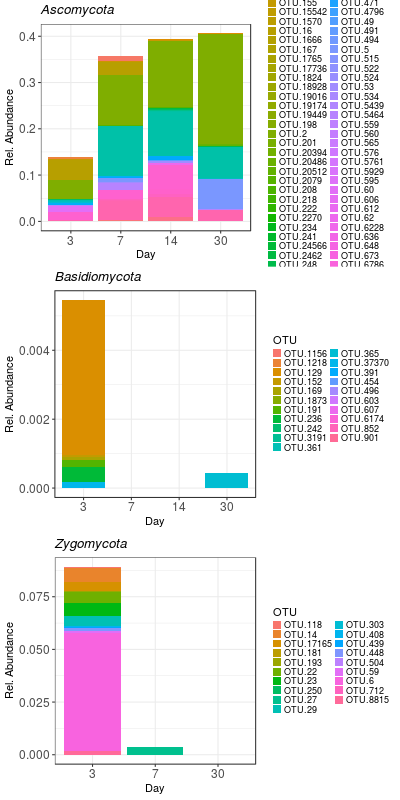

In [14]:
%%R -w 400 -h 800

#scheme = iwanthue()

phyla = c("Ascomycota", "Basidiomycota", "Zygomycota")
#t = "13CCPS"
bulk.df$Rank2 = gsub("p__", "", bulk.df$Rank2)
minP.df.2$Rank2 = gsub("p__", "", minP.df.2$Rank2)

filt = minP.df.2 %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df.2, OTU_day %in% filt$OTU_day)#, 'Relative Abundance' > 0)

d$Rank2 = gsub("p__", "", d$Rank2)


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))

In [15]:
%%R
d %>% 
  group_by(Rank2, Day) %>% 
  summarize(sum_rel_ab = sum(`Relative Abundance`))  


# A tibble: 11 x 3
# Groups:   Rank2 [?]
           Rank2   Day   sum_rel_ab
           <chr> <int>        <dbl>
 1    Ascomycota     3 0.1394120318
 2    Ascomycota     7 0.3567134405
 3    Ascomycota    14 0.3948538886
 4    Ascomycota    30 0.4060461010
 5 Basidiomycota     3 0.0054569785
 6 Basidiomycota     7 0.0000000000
 7 Basidiomycota    14 0.0000000000
 8 Basidiomycota    30 0.0004226543
 9    Zygomycota     3 0.0892136524
10    Zygomycota     7 0.0037399635
11    Zygomycota    30 0.0000000000


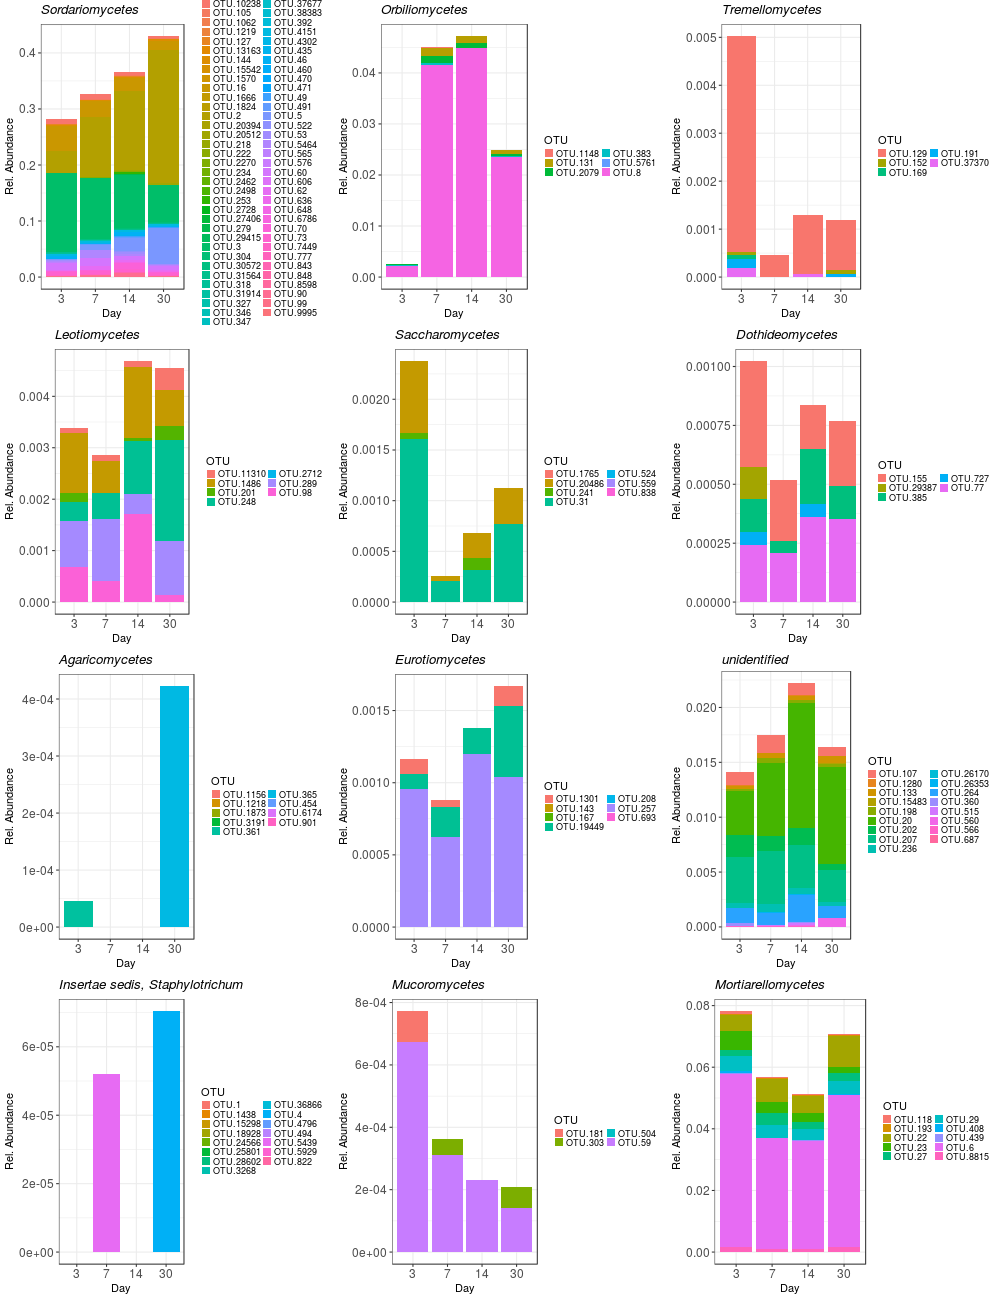

In [25]:
%%R -w 1000 -h 1300

#scheme = iwanthue()

class = c("Sordariomycetes","Orbiliomycetes", "Tremellomycetes", "Leotiomycetes",
          "Saccharomycetes", "Dothideomycetes", "Agaricomycetes", "Eurotiomycetes", "unidentified", 
          "Insertae sedis, Staphylotrichum", "Mucoromycetes", "Mortiarellomycetes")



#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)
minP.df$Rank3 = gsub("c__", "", minP.df$Rank3)

minP.df2 = minP.df %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))


filt = minP.df2 %>% 
    filter(Rank3_mod %in% class) #%>%
   # arrange(Rank3_mod, `Relative Abundance`)




d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d = d %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))

#d$OTU = reorder(d$OTU,d$`Relative Abundance`)


plot = function(r, d) {
    plot.d = d %>% filter(Rank3_mod == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(class, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=3)))

In [26]:
%%R
pdf("../data/figs/all_RA_3_2.pdf", width = 12, height = 16) # Open a new pdf file
grid.arrange(do.call(grid.arrange, c(plots.13CCPS,list(ncol=3)))) # Write the grid.arrange in the file
dev.off() # Close the file

png 
  2 


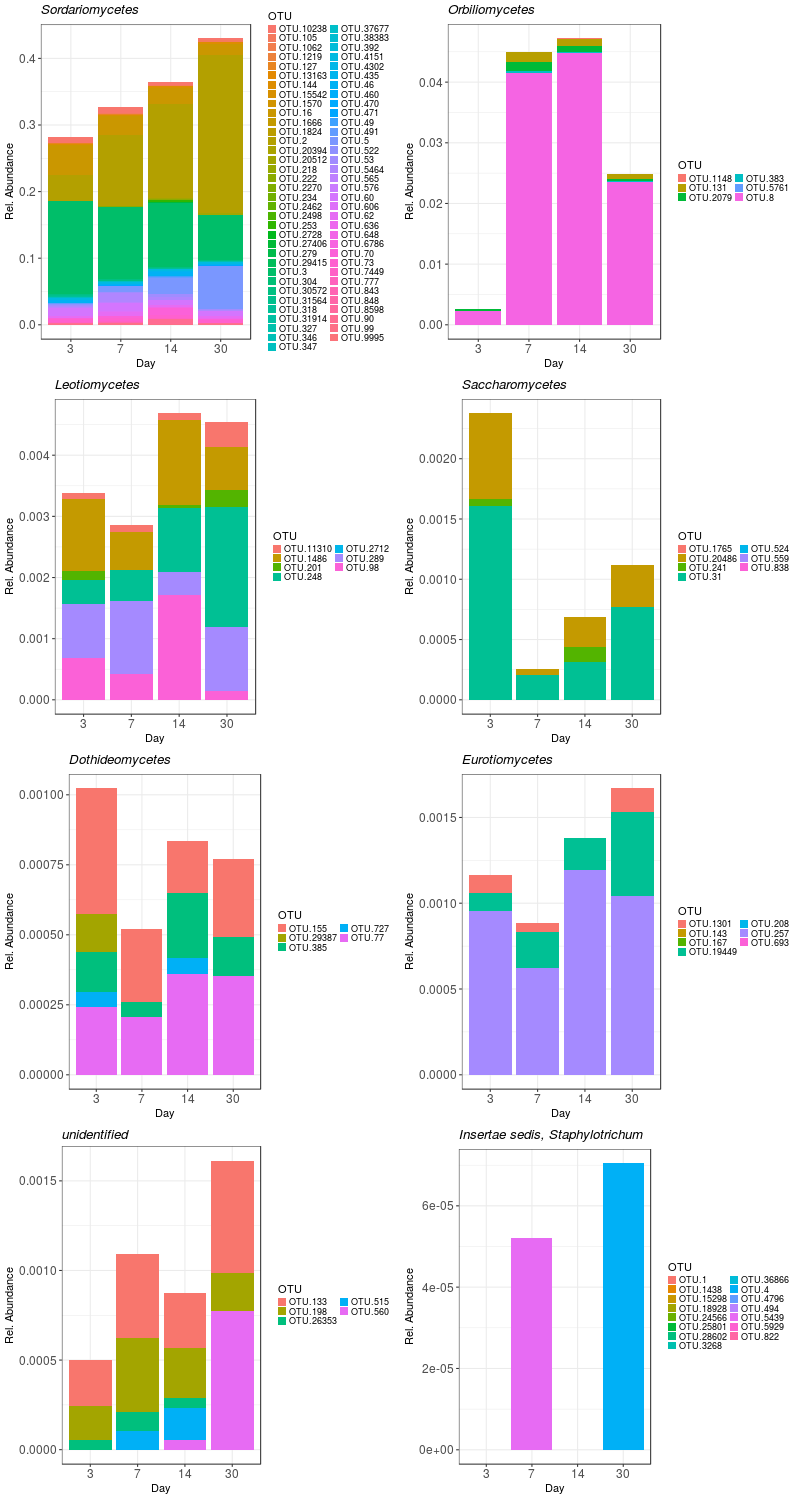

In [88]:
%%R -w 800 -h 1500
#Figure 3 Ascomycota (5 panels), Figure 4 Mucoromycota (2 panels), Figure 5 Basidiomycota (2 panels)


#scheme = iwanthue()

class = c("Sordariomycetes","Orbiliomycetes", "Leotiomycetes",
          "Saccharomycetes", "Dothideomycetes", "Eurotiomycetes", "unidentified", 
          "Insertae sedis, Staphylotrichum")


#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)
minP.df$Rank3 = gsub("c__", "", minP.df$Rank3)

minP.df2 = minP.df %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))


filt = minP.df2 %>% 
    filter(Rank3_mod %in% class) %>%
    filter(Rank2 == "p__Ascomycota")
   # arrange(Rank3_mod, `Relative Abundance`)




d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d = d %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))



plot = function(r, d) {
    plot.d = d %>% filter(Rank3_mod == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(class, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=2)))


In [89]:
%%R
pdf("../data/figs/Actino_RA.pdf", width = 8, height = 24) # Open a new pdf file
grid.arrange(do.call(grid.arrange, c(plots.13CCPS,list(ncol=2)))) # Write the grid.arrange in the file
dev.off() # Close the file

png 
  2 


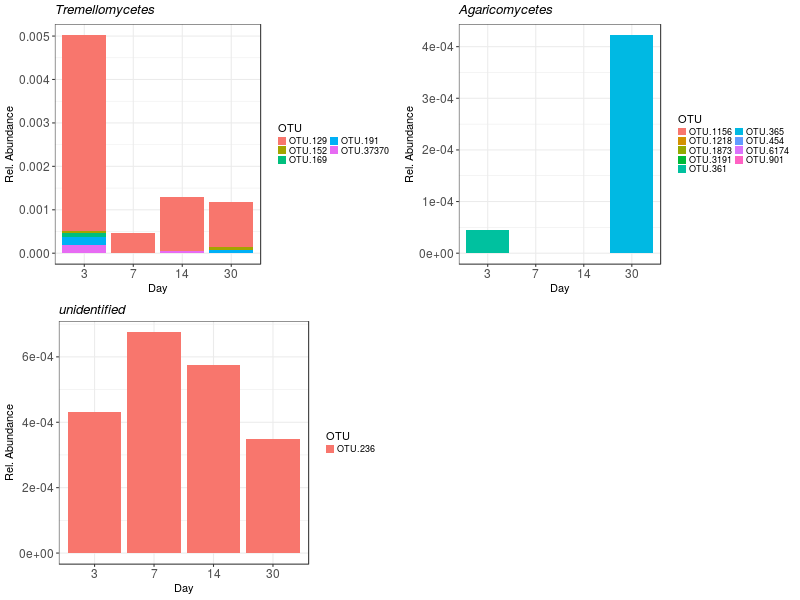

In [55]:
%%R -w 800 -h 600
#Figure 3 Ascomycota (5 panels), Figure 4 Mucoromycota (2 panels), Figure 5 Basidiomycota (2 panels)


#scheme = iwanthue()

class = c("Tremellomycetes", "Agaricomycetes", "unidentified")


#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)
minP.df$Rank3 = gsub("c__", "", minP.df$Rank3)

minP.df2 = minP.df %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))


filt = minP.df2 %>% 
    filter(Rank3_mod %in% class) %>%
    filter(Rank2 == "p__Basidiomycota")
   # arrange(Rank3_mod, `Relative Abundance`)




d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d = d %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))



plot = function(r, d) {
    plot.d = d %>% filter(Rank3_mod == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(class, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=2)))


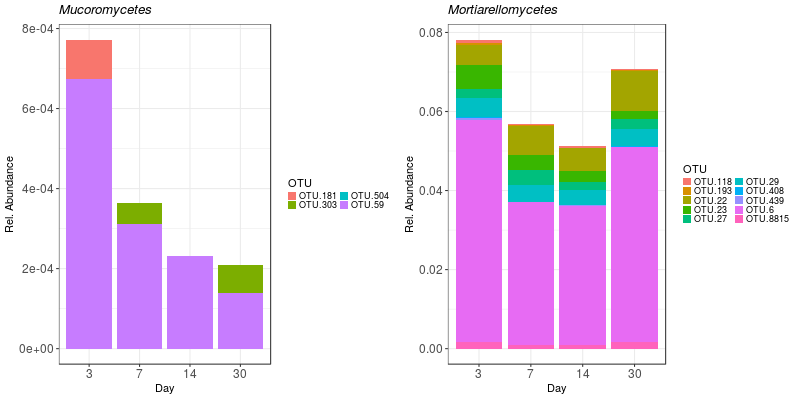

In [60]:
%%R -w 800 -h 400

#scheme = iwanthue()

class = c("Mucoromycetes", "Mortiarellomycetes")


#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)
minP.df$Rank3 = gsub("c__", "", minP.df$Rank3)

minP.df2 = minP.df %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))


filt = minP.df2 %>% 
    filter(Rank3_mod %in% class) %>%
    filter(Rank2 == "p__Zygomycota")
   # arrange(Rank3_mod, `Relative Abundance`)




d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)

d = d %>% mutate(Rank3_mod = if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Staphylotrichum", "Insertae sedis, Staphylotrichum",
                                     if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mucorales", "Mucoromycetes",
                                            if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Mortierellales", "Mortiarellomycetes",
                                                    if_else(Rank3 == "Incertae sedis" & Rank4 == "o__Malasseziales", "Malassezialomycetes",
                                                            if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Leptodiscella", "Leptodiscellomycetes",
                                                                   if_else(Rank3 == "Incertae sedis" & Rank6 == "g__Ochroconis", "Dothideomycetes",
                                                            Rank3)))))))



plot = function(r, d) {
    plot.d = d %>% filter(Rank3_mod == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Day), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))

    p}
    
plots.13CCPS = lapply(class, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=2)))

In [87]:
%%R
pdf("../data/figs/Muco_RA.pdf", width = 8, height = 4) # Open a new pdf file
grid.arrange(do.call(grid.arrange, c(plots.13CCPS,list(ncol=2)))) # Write the grid.arrange in the file
dev.off() # Close the file

png 
  2 


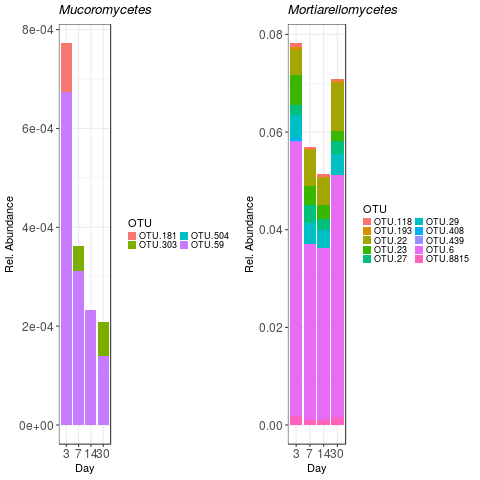

In [83]:
%%R
grid.arrange(do.call(grid.arrange, c(plots.13CCPS,list(ncol=2))))

In [ ]:
%%R
d %>%
  ungroup %>%
  top_n(15, wt = `Relative Abundance`) %>% 
  select(OTU, Rank3, Rank4, Day,`Relative Abundance`) %>% arrange(-`Relative Abundance`)


In [ ]:
%%R
bulk.df %>% 
  filter(OTU %in% c('OTU.1486', 'OTU.98', 'OTU.248', 'OTU.289')) %>%
  ungroup() %>% 
  select(OTU, Rank3, Day,`Relative Abundance`)

In [ ]:
%%R
mdf %>% 
  filter(OTU %in% c('OTU.1486', 'OTU.98', 'OTU.248', 'OTU.289')) %>%
  select(OTU, Rank6, Rank7) %>% unique()

In [ ]:
%%R
d %>%
  ungroup() %>%
  group_by(OTU, Rank2, Rank3) %>%
  summarise(TotRa = sum(`Relative Abundance`)) %>%
  arrange(-TotRa) %>%
  head(n =20) 


In [ ]:
%%R
d %>%
  ungroup() %>%
  group_by(OTU, Rank2, Rank3) %>%
  summarise(TotRa = sum(`Relative Abundance`)) %>%
  arrange(-TotRa) %>%
  head(n =20) 


In [ ]:
%%R -w 800 -h 800

#scheme = iwanthue()

phyla = c("Sordariomycetes", "Agaricomycetes", "Dothideomycetes", 
          "Leotiomycetes", "Orbiliomycetes", "Saccharomycetes", "unidentified")
#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)

filt = minP.df %>% 
    filter(Rank3 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)


    p = ggplot(d, aes(x = Rank3, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Class", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12, angle = 90),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))

    p

In [ ]:
%%R
d %>% 
  ungroup() %>%
  mutate(allRA = sum(`Relative Abundance`))%>% 
  group_by(Rank3) %>% 
  summarise(totalRA = sum((`Relative Abundance`) / allRA))

In [ ]:
%%R
d %>% 
  ungroup() %>%
  mutate(allRA = sum(`Relative Abundance`))%>% 
  group_by(Rank2) %>% 
  summarise(totalRA = sum((`Relative Abundance`) / allRA))

In [ ]:
FileLink("figs/abund_v_time_phyla.pdf")


In [ ]:
 %%R -w 1500 -h 1000
    
    d2= filter(d, `Relative Abundance` > 0 & OTU %in%c("OTU.1219", "OTU.8", "OTU.2"))
    
    p = ggplot(d2, aes(x = factor(Day), y = `Relative Abundance`, fill = Rank3))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
  #  p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
   #                            list(a = t, b = r)))
    
    p = p + facet_wrap(~OTU, scales = "free_y")

    p

In [ ]:
%%R 
head(d)